In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
def advection_rhs(u, t, params):
    
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))

    return real(deriv)

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

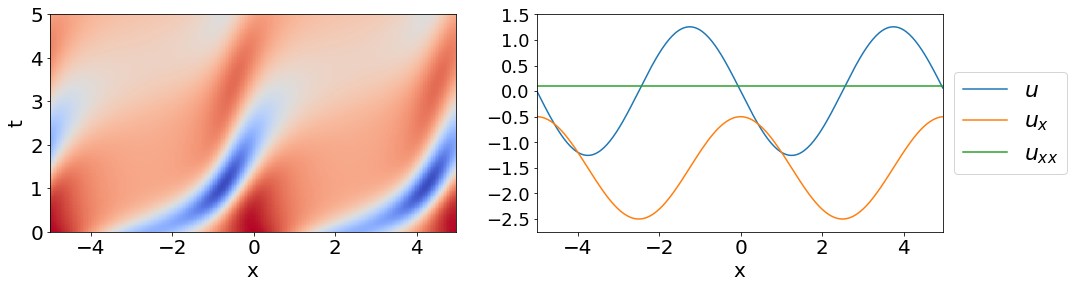

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
# u = u1

In [6]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')

/home/samuel/Dropbox (uwamath)/PDE_SINDy/Parametric_PDE_FIND/parametric-discovery/parametric_pde_find.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [7]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]

In [8]:
xi_true = np.zeros((len(rhs_des),m))
i_u_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{x}'][0]
xi_true[i_u_x,:] = u_x_true

MSE:  0.0399059741197


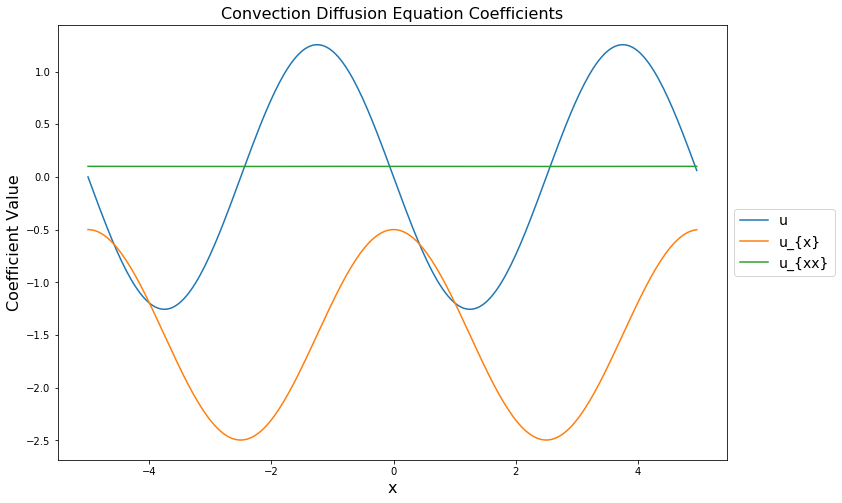

In [9]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_sgtr = Norm(xi-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_sgtr)

MSE:  0.0399059741197


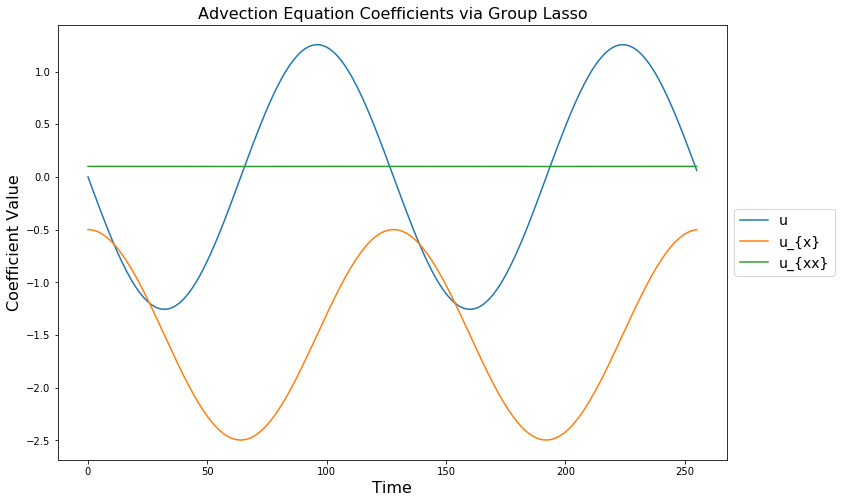

In [10]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n)] for j in range(D)]
Xi_lasso,Lam_lasso,Losses_lasso,History_lasso = TrainGroupLasso(Theta_grouped, Ut_grouped, groups)
xi_lasso = Xi_lasso[np.argmin(Losses_lasso)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso.shape[0]): 
    if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
        if rhs_des[j] == '': plot(xi_lasso[j,:], label = '1')
        else: plot(xi_lasso[j,:], label = rhs_des[j])

title('Advection Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_lasso = Norm(xi_lasso-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_lasso)

In [11]:
un = u + 0.01*std(u)*np.random.randn(n,m)

In [12]:
# Build linear systems
wx = 10  
wt = 10  

deg_x = 6
deg_t = 4
 
Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [13]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

MSE:  0.0391028776242


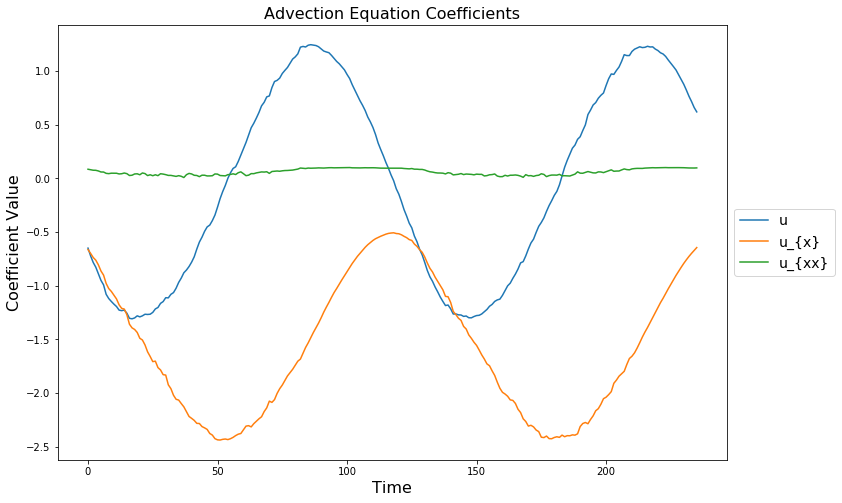

In [14]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Advection Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,wt:-wt])**2/(m*len(rhs_des))
print('MSE: ', mse_noise_sgtr)

MSE:  0.0391028776242


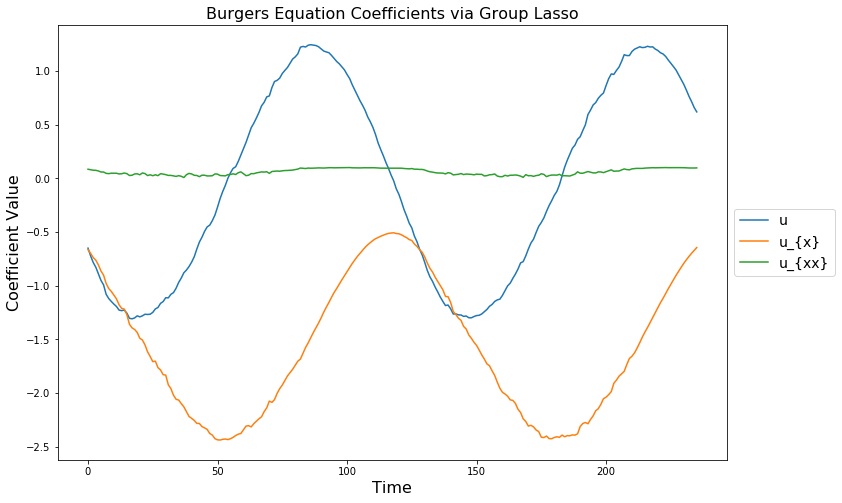

In [15]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n2)] for j in range(D)]
Xi_lasso_n,Lam_lasso_n,Losses_lasso_n,History_lasso_n = TrainGroupLasso(Thetan_grouped, Utn_grouped, groups)
xi_lasso_n = Xi_lasso_n[np.argmin(Losses_lasso_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n.shape[0]): 
    if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        plot(xi_lasso_n[j,:], label = rhs_des[j])

title('Burgers Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_lasso = Norm(xi_lasso_n-xi_true[:,wt:-wt])**2/(m*len(rhs_des))
print('MSE: ', mse_noise_lasso)

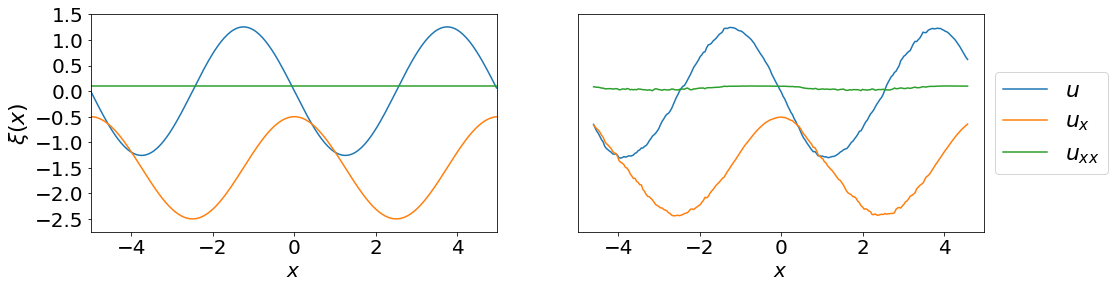

In [16]:
figure(figsize = (16,4))

subplot(1,2,1)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(x,xi[j,:], label = '$'+rhs_des[j]+'$')

ylabel(r'$\xi(x)$', fontsize = fontsize+2)
xlabel(r'$x$', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
ylim(-2.75,1.5)
xlim([x[0],x[-1]])

subplot(1,2,2)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(x[wx:-wx],xi_n[j,:], label = '$'+rhs_des[j]+'$')
        
xticks(fontsize = fontsize)
yticks([])
ylim(-2.75,1.5)
xlabel(r'$x$', fontsize = fontsize)
xlim([x[0],x[-1]])

legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# tight_layout()